In [1]:
import sklearn
import os
import numpy as np
import pandas as pd


# Our evaluation functions¶


In [2]:
# Upsample the minority class (brakes applied)
from sklearn.utils import resample

def upsample(input_df,col="Brake",majority_value=0):
    '''
    Creates a balanced data set from the dataframe provided to it by upsampling the
    minority class, using col as the column_name of classes to be balanced
    '''    
    #Split by row based on the data class
    df_majority = input_df[input_df[col]==majority_value]
    df_minority = input_df[input_df[col]!=majority_value]
    
    df_minority_upsampled = resample(df_minority,
                                  replace=True,
                                  n_samples=df_majority.shape[0],
                                  random_state=444)
    
    df_upsampled = pd.concat([df_majority, df_minority_upsampled])

    #print("Before upsampling:\n",df.Brake.value_counts())
    #print("After upsampling:\n",df_upsampled.Brake.value_counts())
    #print(df_upsampled.describe())
    
    return df_upsampled

In [13]:
from sklearn import metrics
from sklearn import cross_validation
from sklearn.cross_validation import KFold
from sklearn.metrics import confusion_matrix
from yellowbrick.classifier.classification_report import ClassificationReport
from yellowbrick.classifier import ConfusionMatrix


def fit_and_evaluate(df_data,model,label):
    """
    Performs K-fold cross validation to create our evaluation scores, and then retrains the model
    on the entire data set. 
    
    df_data: a dataframe of the data to be modeled, with 'y' as the last column
    model: the sklearn model class that we want to create a new instance of
    label: string printed above the output; not stored in any way
    """
    
    #setup output variables
    scores={'precision':[],'recall':[],'accuracy':[], 'f1':[]}
    cm_list=[]
    cm=np.array([[0,0],[0,0]])
    
    #Perform cross validation training
    for train, test in KFold(df_data.shape[0], n_folds=12,shuffle=True):
        df_train, df_test = df_data.iloc[train], df_data.iloc[test]
        
        df_train_upsampled = upsample(df_train,col="Brake",majority_value=0)
        
        X_train, y_train = df_train_upsampled.iloc[:,:-1], df_train_upsampled.iloc[:,-1]
        X_test, y_test = df_test.iloc[:,:-1], df_test.iloc[:,-1]
        
        estimator = model()
        estimator.fit(X_train, y_train)
        
        expected  = y_test
        predicted = estimator.predict(X_test)
        
        # Append our scores to the tracker
        scores['precision'].append(metrics.precision_score(expected, predicted, average="weighted"))
        scores['recall'].append(metrics.recall_score(expected, predicted, average="weighted"))
        scores['accuracy'].append(metrics.accuracy_score(expected, predicted))
        scores['f1'].append(metrics.f1_score(expected, predicted, average="weighted"))
        
        cm_list.append(confusion_matrix(expected,predicted))
    
    for c in cm_list:
        cm = np.add(cm,cm_list[0])
    
    # Retrain the model on the whole data set
    estimator = model()
    df_train_upsampled = upsample(df_data,col="Brake",majority_value=0)
    estimator.fit(df_train_upsampled.iloc[:,:-1], df_train_upsampled.iloc[:,-1])
    
    print(label)
    print('-----------------')
    print(pd.DataFrame(scores).mean())
    print(cm)
    
    return estimator,scores,cm

In [4]:
def create_comparison_file(estimator,output_name):
    """
    Takes a fitted model, runs it on our unseen data set, and outputs the resulting predictions to a file.
    """
    test_data_path = 'data/2018-01-31.csv'
    test_df = pd.read_csv(test_data_path, sep=',', header=0)
    test_df = test_df.iloc[:,3:]
    
    test_X = test_df.iloc[:,:-1]
    test_y_actual = test_df.iloc[:,-1]
    
    test_y_predicted = estimator.predict(test_X)
    print(confusion_matrix(test_y_actual,test_y_predicted))
    
    #confusion matrix viz
    visualizer = ConfusionMatrix(estimator, classes=[0,1])
    visualizer.score(test_X, test_y_actual)
    visualizer.poof()
    
    #classification report
    visualizer = ClassificationReport(estimator, classes=['No Brake','Brake'])
    visualizer.score(test_X, test_y_actual)  
    g = visualizer.poof() 
    
    test_comparison_df = pd.DataFrame({'actual':test_y_actual,'predicted':test_y_predicted})
    output_path = 'outputs/' + output_name
    test_comparison_df.to_csv(output_path);

# Get the actual data


In [ ]:
data_path = "data/2018-01-29.csv"

# Get our 3 target columns = accel in each direction plus boolean (1/0) for the class braking/not braking
df = pd.read_csv(data_path, sep=",",header=0)
df = df.iloc[:,3:] #don't use first two columns
df.head()

,X,Y,Z,Brake
0,13,59,67,0
1,12,61,66,0
2,14,61,65,0
3,16,60,64,0
4,15,60,64,0


# Train various models and compare them to a separate dataset¶


KN_Classifier
-----------------
accuracy     0.757421
f1           0.794019
precision    0.862849
recall       0.757421
dtype: float64
[[30408  9444]
 [ 1812  3216]]
[[8194 3023]
 [ 303  642]]


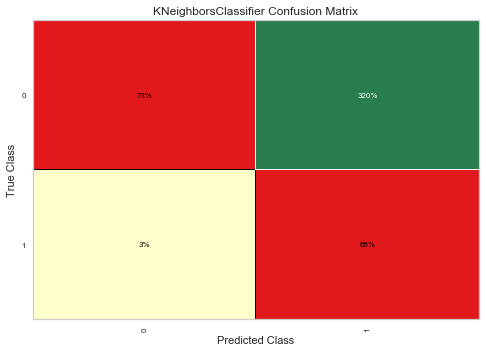

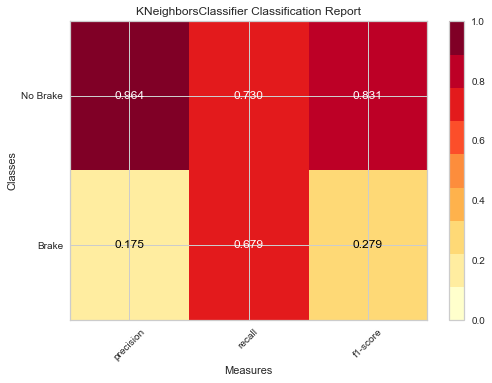

Random_Forest
-----------------
accuracy     0.798984
f1           0.820386
precision    0.852481
recall       0.798984
dtype: float64
[[33468  6048]
 [ 2580  2784]]
[[9136 2081]
 [ 475  470]]


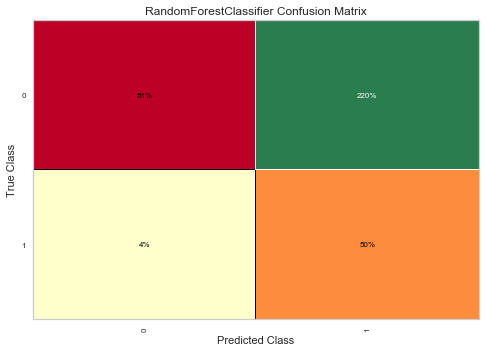

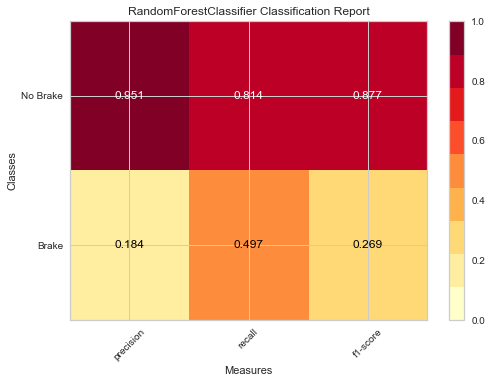

In [ ]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

classification_models = [KNeighborsClassifier,RandomForestClassifier,SVC]
model_labels = ["KN_Classifier","Random_Forest","SVM"]

for (model,label) in zip(classification_models,model_labels):
    data_path = "data/2018-01-29.csv"
    df = pd.read_csv(data_path, sep=",",header=0)
    df = df.iloc[:,3:] #don't use first two columns
    fitted_model, scores, cm = fit_and_evaluate(df,model,label)
    file_name = label + "_comparison.csv"
    create_comparison_file(fitted_model,file_name)


# New evaluation functions

In [2]:
from yellowbrick.features import RadViz,Rank2D
from yellowbrick.features.pca import PCADecomposition
from yellowbrick.features.pcoords import ParallelCoordinates

def feature_viz(df,features,labels,classes):
    import warnings
    warnings.filterwarnings('ignore')

    # Extract the numpy arrays from the data frame
    X = df[features].as_matrix()
    y = df[labels].as_matrix()
    
    
    visualizers = [ParallelCoordinates(classes=classes, features=features,normalize='standard', sample=0.1,),
                   RadViz(classes=classes, features=features),
                   Rank2D(features=features, algorithm='pearson'),
                   PCADecomposition(scale=True, center=False, col=y)]
    
    for visualizer in visualizers:
        visualizer.fit(X, y)                # Fit the data to the visualizer
        visualizer.transform(X)             # Transform the data
        visualizer.poof()                   # Draw/show/poof the data




In [3]:
# Upsample the minority class (brakes applied)
from sklearn.utils import resample

def upsample(input_df,col="Brake",majority_value=0):
    '''
    Creates a balanced data set from the dataframe provided to it by upsampling the
    minority class, using col as the column_name of classes to be balanced
    '''    
    #Split by row based on the data class
    df_majority = input_df[input_df[col]==majority_value]
    df_minority = input_df[input_df[col]!=majority_value]
    
    df_minority_upsampled = resample(df_minority,
                                  replace=True,
                                  n_samples=df_majority.shape[0],
                                  random_state=444)
    
    df_upsampled = pd.concat([df_majority, df_minority_upsampled])

    #print("Before upsampling:\n",df.Brake.value_counts())
    #print("After upsampling:\n",df_upsampled.Brake.value_counts())
    #print(df_upsampled.describe())
    
    return df_upsampled


In [4]:
def add_features(df_data):
    from sklearn.preprocessing import PolynomialFeatures
    new_feat = pd.DataFrame()
    new_feat['mag'] = (np.sqrt(df_data['X']**2) + (df_data['Y']**2) +(df_data['Z']**2))
    new_feat['X_diff'] = df_data['X'].diff()
    new_feat['Y_diff'] = df_data['Y'].diff()
    new_feat['Z_diff'] = df_data['Z'].diff()

    for i in range(1,11):
        for axis in ['X','Y','Z']:        
            colname = axis + '_shift' + str(i)
            new_feat[colname] = df_data[axis].shift(i)

    for i in [2,3,4,5,6,7,8,9,10]:
        for axis in ['X','Y','Z']:        
            colname = axis + '_avg' + str(i)
            new_feat[colname] = df_data[axis].rolling(i).mean().shift(1)   


    axes = df_data.iloc[:,:-1]
    poly = PolynomialFeatures(degree=3, interaction_only=True)
    poly_val = pd.DataFrame(poly.fit_transform(axes))
    poly_val.columns = '1','X1','X2','X3','X1X2','X1X3','X2X3','X1X2X3'
    poly_val.drop(['1'],inplace=True,axis=1)
    
    new_feat = pd.merge(new_feat, poly_val, right_index=True, left_index=True)
    df_data = pd.merge(new_feat,df, right_index=True, left_index=True)
    df_data.dropna(inplace=True)
    df_data.reset_index(inplace=True,drop=True)
    
    return df_data

In [5]:
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.feature_selection import SelectFromModel
def select_features(df_data,feature_selection_model):
    '''
    Selects features based on selectfrommodel 
    '''    
    df_data_upsampled = upsample(df_data,col="Brake",majority_value=0)
    model = feature_selection_model()
    sfm = SelectFromModel(model)
    sfm.fit(df_data_upsampled.iloc[:,:-1], df_data_upsampled.iloc[:,-1])
    features = list(df_data_upsampled.iloc[:,:-1].iloc[:,sfm.get_support(indices=True)])
    return features

In [6]:
from sklearn import metrics
from sklearn import cross_validation
from sklearn.cross_validation import KFold
from sklearn.metrics import confusion_matrix
from yellowbrick.classifier.classification_report import ClassificationReport


def fit_and_evaluate_new(df_data,feature_selection_model,model,label):
    """
    Performs K-fold cross validation to create our evaluation scores, and then retrains the model
    on the entire data set. 
    
    df_data: a dataframe of the data to be modeled, with 'y' as the last column
    model: the sklearn model class that we want to create a new instance of
    label: string printed above the output; not stored in any way
    """
    
    #setup output variables
    scores={'precision':[],'recall':[],'accuracy':[], 'f1':[]}
    cm_list=[]
    cm=np.array([[0,0],[0,0]])
    
    #add more features
    df_data = add_features(df_data)
    new_columns = select_features(df_data,feature_selection_model)
    
    new_columns.append('Brake')
    df_data = df_data[new_columns]

    
    #Perform cross validation training
    for train, test in KFold(df_data.shape[0], n_folds=12,shuffle=True):
        df_train, df_test = df_data.iloc[train], df_data.iloc[test]
        
        
        df_train_upsampled = upsample(df_train,col="Brake",majority_value=0)
        
        X_train, y_train = df_train_upsampled.iloc[:,:-1], df_train_upsampled.iloc[:,-1]
        X_test, y_test = df_test.iloc[:,:-1], df_test.iloc[:,-1]
        
        estimator = model()
        estimator.fit(X_train, y_train)
        
        expected  = y_test
        predicted = estimator.predict(X_test)
        
        # Append our scores to the tracker
        scores['precision'].append(metrics.precision_score(expected, predicted, average="weighted"))
        scores['recall'].append(metrics.recall_score(expected, predicted, average="weighted"))
        scores['accuracy'].append(metrics.accuracy_score(expected, predicted))
        scores['f1'].append(metrics.f1_score(expected, predicted, average="weighted"))
        
        cm_list.append(confusion_matrix(expected,predicted))
        

    
    for c in cm_list:
        cm = np.add(cm,cm_list[0])
        
    
    # Retrain the model on the whole data set df_train_upsampled was here - changed
    estimator = model()
    df_data_upsampled = upsample(df_data,col="Brake",majority_value=0)
    estimator.fit(df_data_upsampled.iloc[:,:-1], df_data_upsampled.iloc[:,-1])
                                      
    print(label)
    print('-----------------')
    print(pd.DataFrame(scores).mean())
    print(cm)
    print(new_columns)

    
    return estimator,scores,cm,new_columns


/Users/kbelita/KVB_ENV/envpy3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [7]:
def create_comparison_file_new(estimator,output_name,columns):
    """
    Takes a fitted model, runs it on our unseen data set, and outputs the resulting predictions to a file.
    """
    test_data_path = 'data/2018-01-31.csv'
    test_df = pd.read_csv(test_data_path, sep=',', header=0)
    test_df = test_df.iloc[:,3:]
    
    test_df = add_features(test_df)
    test_df = test_df[columns]
    test_X = test_df.iloc[:,:-1]
    test_y_actual = test_df.iloc[:,-1]
    
    test_y_predicted = estimator.predict(test_X)
    print(confusion_matrix(test_y_actual,test_y_predicted))
    
    #confusion matrix viz
    visualizer = ConfusionMatrix(estimator, classes=[0,1])
    visualizer.score(test_X, test_y_actual)
    visualizer.poof()
    
    #classification report
    visualizer = ClassificationReport(estimator, classes=['No Brake','Brake'])
    visualizer.score(test_X, test_y_actual)  
    g = visualizer.poof() 

    test_comparison_df = pd.DataFrame({'actual':test_y_actual,'predicted':test_y_predicted})
    output_path = 'outputs/' + output_name
    test_comparison_df.to_csv(output_path);


# Get the actual data


In [8]:
data_path = "data/2018-01-29.csv"

# Get our 3 target columns = accel in each direction plus boolean (1/0) for the class braking/not braking
df = pd.read_csv(data_path, sep=",",header=0)
df = df.iloc[:,3:] #don't use first two columns
df.head()

,X,Y,Z,Brake
0,13,59,67,0
1,12,61,66,0
2,14,61,65,0
3,16,60,64,0
4,15,60,64,0


#  Feature Analysis

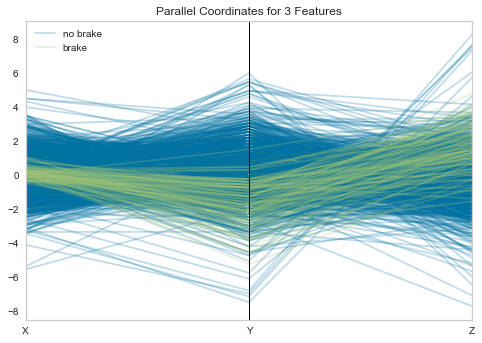

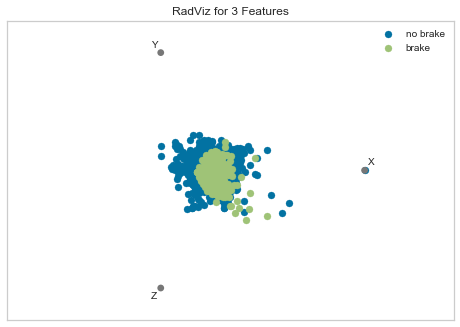

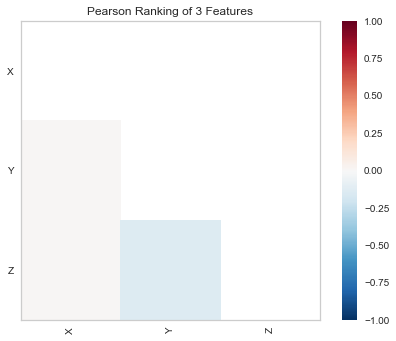

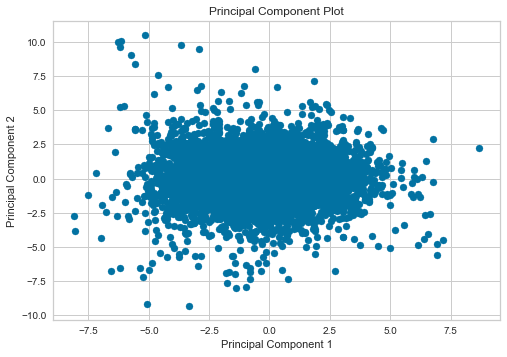

In [9]:
features = ["X","Y","Z"]
classes = ["no brake","brake"]
labels = "Brake"
feature_viz(df,features,labels,classes)

adding more features

In [10]:
data_path = "data/2018-01-29.csv"

# Get our 3 target columns = accel in each direction plus boolean (1/0) for the class braking/not braking
df = pd.read_csv(data_path, sep=",",header=0)
df = df.iloc[:,3:] #don't use first two columns
df.head()

df = add_features(df)
df.columns.values


array(['mag', 'X_diff', 'Y_diff', 'Z_diff', 'X_shift1', 'Y_shift1',
       'Z_shift1', 'X_shift2', 'Y_shift2', 'Z_shift2', 'X_shift3',
       'Y_shift3', 'Z_shift3', 'X_shift4', 'Y_shift4', 'Z_shift4',
       'X_shift5', 'Y_shift5', 'Z_shift5', 'X_shift6', 'Y_shift6',
       'Z_shift6', 'X_shift7', 'Y_shift7', 'Z_shift7', 'X_shift8',
       'Y_shift8', 'Z_shift8', 'X_shift9', 'Y_shift9', 'Z_shift9',
       'X_shift10', 'Y_shift10', 'Z_shift10', 'X_avg2', 'Y_avg2',
       'Z_avg2', 'X_avg3', 'Y_avg3', 'Z_avg3', 'X_avg4', 'Y_avg4',
       'Z_avg4', 'X_avg5', 'Y_avg5', 'Z_avg5', 'X_avg6', 'Y_avg6',
       'Z_avg6', 'X_avg7', 'Y_avg7', 'Z_avg7', 'X_avg8', 'Y_avg8',
       'Z_avg8', 'X_avg9', 'Y_avg9', 'Z_avg9', 'X_avg10', 'Y_avg10',
       'Z_avg10', 'X1', 'X2', 'X3', 'X1X2', 'X1X3', 'X2X3', 'X1X2X3', 'X',
       'Y', 'Z', 'Brake'], dtype=object)

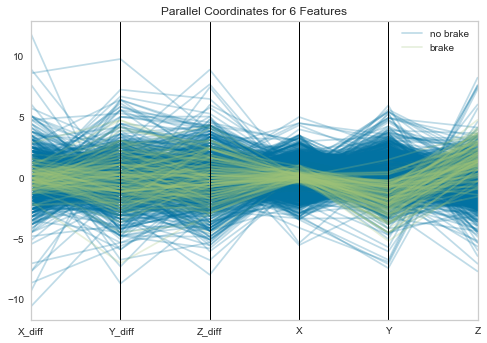

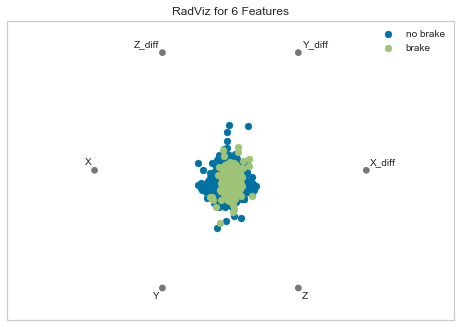

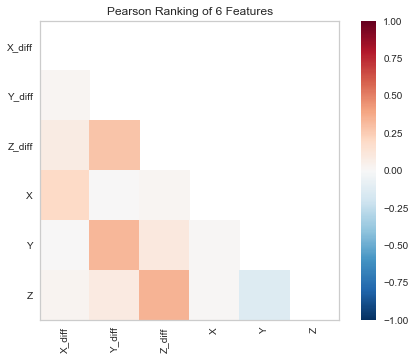

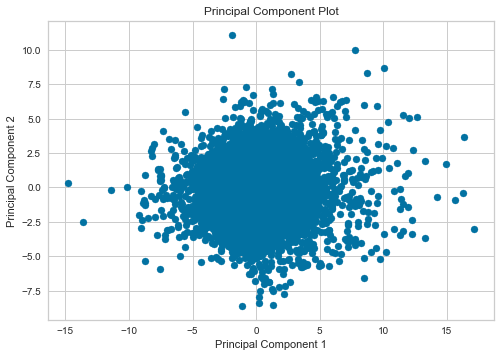

In [11]:
df = df[[ 'X_diff', 'Y_diff', 'Z_diff','X','Y','Z','Brake']]
features = [ 'X_diff', 'Y_diff', 'Z_diff','X','Y','Z']
classes = ["no brake","brake"]
labels = "Brake"
feature_viz(df,features,labels,classes)

# Train various models and compare them to a separate dataset

Lasso
-----------------


KN_Classifier
-----------------
accuracy     0.805180
f1           0.830316
precision    0.876068
recall       0.805180
dtype: float64
[[32808  6552]
 [ 1764  3744]]
['mag', 'Y_shift4', 'Z_shift4', 'Y_shift5', 'Z_shift5', 'Y_shift6', 'Z_shift6', 'Y_shift7', 'Z_shift7', 'Y_shift8', 'Z_shift8', 'Y_shift9', 'Y_shift10', 'Z_shift10', 'X1X2', 'X1X3', 'X2X3', 'Brake']
[[8271 2843]
 [ 736  302]]


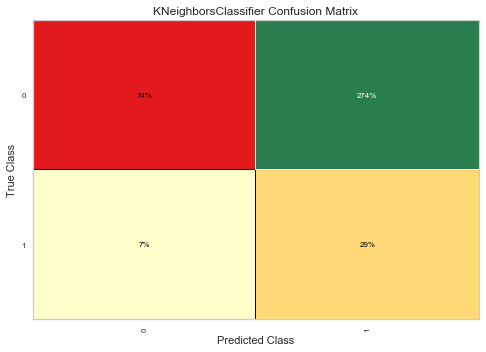

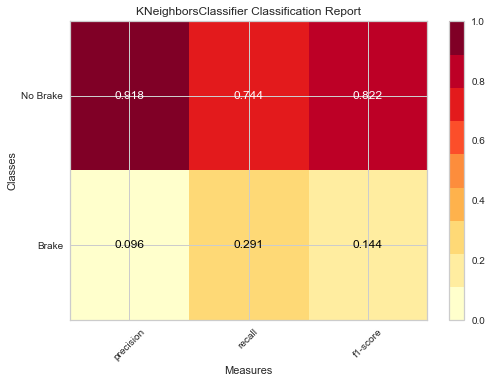

Random_Forest
-----------------
accuracy     0.921047
f1           0.914911
precision    0.914068
recall       0.921047
dtype: float64
[[37932   948]
 [ 2964  3024]]
['mag', 'Y_shift4', 'Z_shift4', 'Y_shift5', 'Z_shift5', 'Y_shift6', 'Z_shift6', 'Y_shift7', 'Z_shift7', 'Y_shift8', 'Z_shift8', 'Y_shift9', 'Y_shift10', 'Z_shift10', 'X1X2', 'X1X3', 'X2X3', 'Brake']
[[10104  1010]
 [  976    62]]


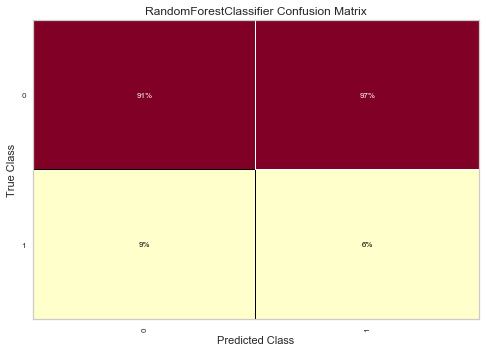

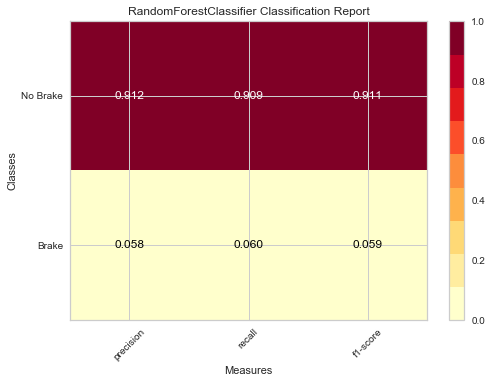

In [ ]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

feature_selection_models = [Lasso,Ridge,ElasticNet]
feature_selection_labels = ["Lasso","Ridge","ElasticNet"]
classification_models = [KNeighborsClassifier,RandomForestClassifier,SVC]
model_labels = ["KN_Classifier","Random_Forest","SVM"]

for (feature_selection_model,feature_selection_label) in zip(feature_selection_models,feature_selection_labels):
    print (feature_selection_label)
    print('-----------------\n\n')
    for (model,label) in zip(classification_models,model_labels):
        data_path = "data/2018-01-29.csv"
        df = pd.read_csv(data_path, sep=",",header=0)
        df = df.iloc[:,3:] #don't use first two columns
        fitted_model, scores, cm, new_columns = fit_and_evaluate_new(df,feature_selection_model,model,label)
        file_name = feature_selection_label + label + "comparison.csv"
        create_comparison_file_new(fitted_model,file_name,new_columns)
    